In [1]:
!nvidia-smi

Wed Feb  7 06:03:46 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
!pip install datasets --quiet
!pip install timm --quiet
!pip install torchmetrics --quiet
!pip install --upgrade gdown --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.2/840.2 kB 5.5 MB/s eta 0:00:00


In [3]:
from tqdm import tqdm
from PIL import Image
from typing import List, Tuple, Dict, Optional, Any
from dataclasses import dataclass

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
from torch.utils.data import Dataset, DataLoader

from datasets import load_dataset
import torchmetrics
import timm

# Configuration of the parameters

In [4]:
@dataclass
class Config:

  image_size = 224
  projection_dim = 256

  text_model = "distilbert-base-uncased"
  max_tokens = 24

  temperature = 0.05

  batch_size = 64
  num_workers = 1

  num_epochs = 10

  image_encoder_lr = 1e-4
  text_encoder_lr = 1e-5
  projection_head_lr = 1e-3
  weight_decay = 1e-4

# Loading Dataset Flickr

In [5]:
def load_flickr(version: str = "flickr8k") -> Dataset:
  if version == "flickr8k":
    dataset = load_dataset("jxie/flickr8k", cache_dir="./huggingface_data")
  elif version == "flickr30k":
    dataset = load_dataset("nlphuji/flickr30k", cache_dir="./huggingface_data")
  else:
    raise NotImplemented(f"Unknown dataset version: {version}")
  return dataset

In [6]:
flickr8k_dataset = load_flickr(version="flickr8k")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/6000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [7]:
print(flickr8k_dataset)

DatasetDict({
    train: Dataset({
        features: ['image', 'caption_0', 'caption_1', 'caption_2', 'caption_3', 'caption_4'],
        num_rows: 6000
    })
    validation: Dataset({
        features: ['image', 'caption_0', 'caption_1', 'caption_2', 'caption_3', 'caption_4'],
        num_rows: 1000
    })
    test: Dataset({
        features: ['image', 'caption_0', 'caption_1', 'caption_2', 'caption_3', 'caption_4'],
        num_rows: 1000
    })
})


caption_0: Two asian children smile while hugging each other .
caption_1: Two children grin and hug each other .
caption_2: Two children hug and smile .
caption_3: Two children smile for the camera .
caption_4: Two kids hugging each other .


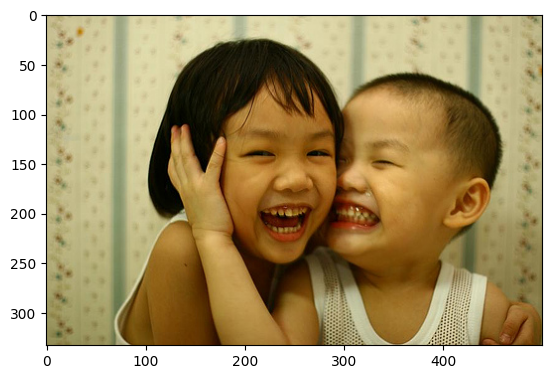

In [8]:
import random
import matplotlib.pyplot as plt

data_item = random.choice(flickr8k_dataset['train'])
plt.imshow(data_item['image'])
for key in data_item:
  if key.startswith('caption'):
    print(f"{key}: {data_item[key]}")


## Text Data Preparation

In [9]:
from transformers import DistilBertModel, DistilBertConfig, DistilBertTokenizer

In [10]:
tokenizer = DistilBertTokenizer.from_pretrained(Config.text_model)

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [11]:
captions = ['Two boys', 'Small cuckoo', 'xewrfjjasderda']

for caption in captions:
  print(f'Tekst: {caption}')
  tokens = tokenizer(caption, add_special_tokens=True, padding='max_length',
                     truncation=True, max_length=Config.max_tokens)
  print(f'Wynik tokenizacji: {tokens}')
  decoded_txt = tokenizer.decode(tokens['input_ids'])
  print(f'Zdekodowane tokeny: {decoded_txt}')
  print()

Tekst: Two boys
Wynik tokenizacji: {'input_ids': [101, 2048, 3337, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}
Zdekodowane tokeny: [CLS] two boys [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]

Tekst: Small cuckoo
Wynik tokenizacji: {'input_ids': [101, 2235, 29010, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}
Zdekodowane tokeny: [CLS] small cuckoo [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]

Tekst: xewrfjjasderda
Wynik tokenizacji: {'input_ids': [101, 1060, 7974, 12881, 3501, 17386, 4063, 2850, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 

## Image Data Preparation

In [12]:
from torchvision.transforms import v2

def get_image_transforms(mode: str = "train"):
  if mode == "train":
    transforms = v2.Compose([
        v2.ToImage(),                         # Convert a tensor, ndarray, or PIL Image to Image; does not scale values
        v2.ToDtype(torch.uint8, scale=True),  # Optional, most input are already uint8 at this point
        v2.RandomResizedCrop(size=(Config.image_size, Config.image_size), antialias=True),
        v2.RandomHorizontalFlip(p=0.5),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
  else:
    transforms = v2.Compose([
        v2.ToImage(),                         # Convert to tensor, only needed if you had a PIL image
        v2.ToDtype(torch.uint8, scale=True),  # Optional, most input are already uint8 at this point
        v2.Resize(size=(Config.image_size, Config.image_size), antialias=True),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
  return transforms


In [13]:
image = flickr8k_dataset['train'][0]['image']
transforms = get_image_transforms('train')
x = transforms(image)
print(type(x))
print(x.shape)

<class 'torchvision.tv_tensors._image.Image'>
torch.Size([3, 224, 224])


In [14]:
class CLIPDataset(Dataset):
  def __init__(self, dataset: Dataset, tokenizer, image_transforms):
    # dataset: Flickr dataset
    # tokenizer: Text tokenizer
    # transforms: Image transforms
    self.dataset = dataset
    self.tokenizer = tokenizer
    self.image_transforms = image_transforms

    # Tokenize image captions
    self.raw_captions = []
    self.tokenized_captions = []
    for data_item in tqdm(dataset, desc="Caption tokenization..."):
      captions = [data_item[key] for key in data_item if key.startswith("caption")]
      self.raw_captions.append(captions)
      temp = tokenizer(captions, add_special_tokens=True, padding='max_length',
                       truncation=True, max_length=Config.max_tokens)
      self.tokenized_captions.append(temp)

  def __getitem__(self, idx) -> Dict[str, Any]:
    image = self.dataset[idx]['image']

    # Apply data augmentation to the image, convert to the tensor and normalize
    image = self.image_transforms(image)

    # Select a random caption
    k = random.randrange(len(self.tokenized_captions[idx]))
    tokenized_caption = {key: torch.as_tensor(values[k]) for key, values
                         in self.tokenized_captions[idx].items()}
    data_item = {
        'image': image,
        'tokenized_caption': tokenized_caption,
        'caption': self.raw_captions[idx][k]
        }
    return data_item

  def __len__(self) -> int:
    return len(self.dataset)

In [15]:
training_dataset = CLIPDataset(flickr8k_dataset['train'], tokenizer, get_image_transforms(mode="train"))
val_dataset = CLIPDataset(flickr8k_dataset['validation'], tokenizer, get_image_transforms(mode="val"))



Caption tokenization...: 100%|██████████| 1000/1000 [00:04<00:00, 211.11it/s]


# CLIP Model

## Projection Head

In [23]:
class ProjectionHead(nn.Module):
  def __init__(self, embedding_dim: int, projection_dim: int):
    super().__init__()
    self.projection_dim = projection_dim

    self.embedding_dim = embedding_dim
    self.projection = nn.Linear(self.embedding_dim, self.projection_dim, bias=False)

  def forward(self, x: Tensor) -> Tensor:
    y = self.projection(x)
    z = nn.functional.normalize(y, p=2, dim=1)
    return z

## Text Encoder

In [25]:
class TextEncoder(nn.Module):
  def __init__(self) -> None:
    super().__init__()
    self.backbone = DistilBertModel.from_pretrained(Config.text_model)
    self.embedding_dim = self.backbone.config.dim
    # we are using the CLS token hidden representation as the sentence's embedding
    self.CLS_token_idx = 0

  def forward(self, input_ids: Tensor, attention_mask: Tensor) -> Tensor:
    x = self.backbone(input_ids=input_ids, attention_mask=attention_mask)
    last_hidden_state = x.last_hidden_state
    # last_hidden_state is (batch_size, sequence_length, embedding_dim) tensor
    x = last_hidden_state[:, self.CLS_token_idx, :]
    # x is (batch_size, embedding_dim) tensor
    return x

## Image Encoder

In [26]:
class ImageEncoder(nn.Module):
  def __init__(self) -> None:
    super().__init__()
    self.backbone = timm.create_model('resnet50', pretrained=True,
                                      num_classes=0)
    self.embedding_dim = self.backbone.feature_info[-1]['num_chs']
    self.projection = ProjectionHead(self.embedding_dim, Config.projection_dim)

  def forward(self, x: Tensor) -> Tensor:
    # x is (batch_size, 3, image_size, image_size) tensor

    x = self.backbone(x)
    x = self.projection(x)
    
    # x is (batch_size, projection_dim) tensor
    return x


In [28]:
def count_parameters(model: nn.Module) -> Tuple[int, int]:
  trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
  all_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
  return trainable_params, all_params

## Model definition

In [29]:
class CLIPModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.text_encoder = TextEncoder()
    self.image_encoder = ImageEncoder()

  def forward(self, batch):
    text = batch['tokenized_caption']
    text_embeddings = self.text_encoder(input_ids=text["input_ids"], attention_mask=text["attention_mask"])
    image_embeddings = self.image_encoder(batch["image"])
    return text_embeddings, image_embeddings

  def print_info(self):
    print(f"Text embedding dimensionality: {self.text_encoder.embedding_dim}   projected: {self.text_encoder.projection.projection_dim}")
    print(f"Image embedding dimensionality: {self.image_encoder.embedding_dim}   projected: {self.image_encoder.projection.projection_dim}")
    nt, na = count_parameters(self.text_encoder)
    print(f"Text encoder parameters (trainable/all): {nt} / {na}")
    nt, na = count_parameters(self.image_encoder)
    print(f"Image encoder parameters (trainable/all): {nt} / {na}")
    nt, na = count_parameters(self)
    print(f"All parameters (trainable/all): {nt} / {na}")


## Loss definition

In [30]:
def CLIP_loss(text_embeddings: Tensor, image_embeddings: Tensor) -> Tuple[Tensor, float, float]:
    assert text_embeddings.shape == image_embeddings.shape
    assert text_embeddings.device == image_embeddings.device

    n = len(text_embeddings)        # Batch size

    # Create labels tensor = tensor([0, 1,..., n-1])
    labels = torch.arange(n).to(text_embeddings.device)

    logits = (text_embeddings @ image_embeddings.T) / Config.temperature
    img_acc, cap_acc = calc_metrics(logits)

    # Calculate cross entropy losses along axis 0 and 1
    loss_i = F.cross_entropy(logits.transpose(0, 1), labels, reduction="mean")
    loss_t = F.cross_entropy(logits, labels, reduction="mean")

    # Calculate the final loss
    loss = (loss_i + loss_t) / 2

    return loss, img_acc, cap_acc

@torch.no_grad
def calc_metrics(logits: torch.Tensor) -> Tuple[float, float]:
    y = torch.arange(len(logits)).to(logits)
    img2cap_match_idx = logits.argmax(dim=1)
    cap2img_match_idx = logits.argmax(dim=0)

    img_acc = (img2cap_match_idx == y).float().mean().item()
    cap_acc = (cap2img_match_idx == y).float().mean().item()

    return img_acc, cap_acc

# Training

In [31]:
dataloader = {
    'train': DataLoader(training_dataset, batch_size=Config.batch_size, num_workers=Config.num_workers, shuffle=True),
    'val': DataLoader(val_dataset, batch_size=Config.batch_size, num_workers=Config.num_workers)
}


In [32]:
clip_model = CLIPModel()
clip_model.print_info()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
clip_model.to(device)

params = [
  {"params": clip_model.text_encoder.backbone.parameters(), "lr": Config.text_encoder_lr},
  {"params": clip_model.image_encoder.backbone.parameters(), "lr": Config.image_encoder_lr},
  {"params": clip_model.text_encoder.projection.parameters(), "lr": Config.projection_head_lr, "weight_decay": Config.weight_decay},
  {"params": clip_model.image_encoder.projection.parameters(), "lr": Config.projection_head_lr, "weight_decay": Config.weight_decay},
]
optimizer = torch.optim.AdamW(params, weight_decay=0.)


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Text embedding dimensionality: 768   projected: 256
Image embedding dimensionality: 2048   projected: 256
Text encoder parameters (trainable/all): 66559488 / 66559488
Image encoder parameters (trainable/all): 24032320 / 24032320
All parameters (trainable/all): 90591808 / 90591808


In [33]:
from tqdm import tqdm

# Per-batch metrics
loss_metric = torchmetrics.aggregation.MeanMetric()
img_acc_metric = torchmetrics.aggregation.MeanMetric()
cap_acc_metric = torchmetrics.aggregation.MeanMetric()

for epoch in range(Config.num_epochs):
  for phase in ['train', 'val']:
    loss_metric.reset()
    img_acc_metric.reset()
    cap_acc_metric.reset()

    if phase == 'train':
      clip_model.train()
    else:
      clip_model.eval()

    for batch in tqdm(dataloader[phase]):
      batch['image'] = batch['image'].to(device)
      batch['tokenized_caption'] = {k: v.to(device) for k, v in batch['tokenized_caption'].items()}
      with torch.set_grad_enabled(phase=='train'):
        text_embeddings, image_embeddings = clip_model(batch)
        loss, img_acc, cap_acc = CLIP_loss(text_embeddings, image_embeddings)

      loss_metric.update(loss.item())
      img_acc_metric.update(img_acc)
      cap_acc_metric.update(cap_acc)

      # Backward pass and optimization
      if phase == 'train':

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if phase == 'train':
      print(f"({phase})  epoch: {epoch+1}/{Config.num_epochs}  Loss: {loss_metric.compute():.3f}")
    else:
      print(f"({phase})  epoch: {epoch+1}/{Config.num_epochs}  Loss: {loss_metric.compute():.3f}  img2text acc: {img_acc_metric.compute():.3f}  txt2img acc: {cap_acc_metric.compute():.3f}")


100%|██████████| 94/94 [01:09<00:00,  1.36it/s]


(train)  epoch: 1/10  Loss: 2.840


100%|██████████| 16/16 [00:07<00:00,  2.09it/s]


(val)  epoch: 1/10  Loss: 1.867  img2text acc: 0.410  txt2img acc: 0.436


100%|██████████| 94/94 [01:08<00:00,  1.37it/s]


(train)  epoch: 2/10  Loss: 1.834


100%|██████████| 16/16 [00:07<00:00,  2.18it/s]


(val)  epoch: 2/10  Loss: 1.448  img2text acc: 0.529  txt2img acc: 0.545


100%|██████████| 94/94 [01:10<00:00,  1.33it/s]


(train)  epoch: 3/10  Loss: 1.509


100%|██████████| 16/16 [00:06<00:00,  2.31it/s]


(val)  epoch: 3/10  Loss: 1.332  img2text acc: 0.564  txt2img acc: 0.571


100%|██████████| 94/94 [01:12<00:00,  1.29it/s]


(train)  epoch: 4/10  Loss: 1.291


100%|██████████| 16/16 [00:07<00:00,  2.09it/s]


(val)  epoch: 4/10  Loss: 1.246  img2text acc: 0.608  txt2img acc: 0.621


100%|██████████| 94/94 [01:12<00:00,  1.29it/s]


(train)  epoch: 5/10  Loss: 1.150


100%|██████████| 16/16 [00:07<00:00,  2.26it/s]


(val)  epoch: 5/10  Loss: 1.198  img2text acc: 0.641  txt2img acc: 0.644


100%|██████████| 94/94 [01:13<00:00,  1.28it/s]


(train)  epoch: 6/10  Loss: 1.043


100%|██████████| 16/16 [00:07<00:00,  2.11it/s]


(val)  epoch: 6/10  Loss: 1.242  img2text acc: 0.605  txt2img acc: 0.618


100%|██████████| 94/94 [01:13<00:00,  1.28it/s]


(train)  epoch: 7/10  Loss: 0.965


100%|██████████| 16/16 [00:06<00:00,  2.30it/s]


(val)  epoch: 7/10  Loss: 1.197  img2text acc: 0.636  txt2img acc: 0.635


100%|██████████| 94/94 [01:13<00:00,  1.28it/s]


(train)  epoch: 8/10  Loss: 0.889


100%|██████████| 16/16 [00:07<00:00,  2.10it/s]


(val)  epoch: 8/10  Loss: 1.136  img2text acc: 0.653  txt2img acc: 0.647


100%|██████████| 94/94 [01:13<00:00,  1.28it/s]


(train)  epoch: 9/10  Loss: 0.828


100%|██████████| 16/16 [00:06<00:00,  2.31it/s]


(val)  epoch: 9/10  Loss: 1.138  img2text acc: 0.645  txt2img acc: 0.651


100%|██████████| 94/94 [01:13<00:00,  1.28it/s]


(train)  epoch: 10/10  Loss: 0.753


100%|██████████| 16/16 [00:07<00:00,  2.06it/s]

(val)  epoch: 10/10  Loss: 1.113  img2text acc: 0.644  txt2img acc: 0.658


In [34]:
import gc

del batch
del loss
del text_embeddings
del image_embeddings
del optimizer
gc.collect()
torch.cuda.empty_cache()
!nvidia-smi

Wed Feb  7 06:28:32 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   75C    P0              49W /  70W |   2021MiB / 15360MiB |     40%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

#5 Wykorzystanie wytrenowanego modelu


Funkcje pomocnicze do konwersji pojedycznego elementu (obrazu, tekstu i pary obrazu z tekstem) na jednoelementowy wsad.

Modele sieci neuronowych w PyTorch (obiekty klasy `torch.nn.Module`) wymagają na wejściu wsadów. Jeśli chcemy przetworzyć pojedynczy element ze zbioru danych, musimy zamienić go na jednoelementowy wsad.

In [35]:
def img_to_batch(img_tensor: Tensor, device) -> Tensor:
  # Convert image given as a tensor to one element batch and move to the device
  return img_tensor.unsqueeze(0).to(device)

def txt_to_batch(tokenized_txt: Dict[str, Any], device) -> Dict[str, Tensor]:
  # Convert tokenized text to one element batch and move to the
  return {key: torch.as_tensor(tokenized_txt[key]).unsqueeze(0).to(device) for key in tokenized_txt}

def make_batch(data_item, device):
  # Convert a data item to one-element batch and move to the device
  data_item['image'] = img_to_batch(data_item['image'], device)
  data_item['tokenized_caption'] = txt_to_batch(data_item['tokenized_caption'], device)
  data_item['caption'] = [data_item['caption']]
  return data_item

## Tests

Image tensor shape: torch.Size([1, 3, 224, 224])
Image embedding shape: torch.Size([256])


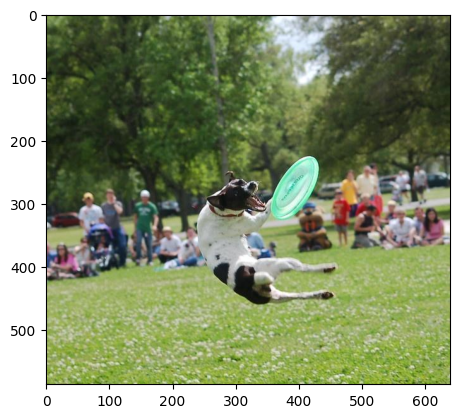

In [110]:
import requests
url = 'https://i.imgur.com/6WA63ka.jpeg'
input_image = Image.open(requests.get(url, stream=True).raw)
plt.imshow(input_image)

transform_to_tensor = get_image_transforms('test')
input_img_tensor = transform_to_tensor(input_image)
input_img_batch = img_to_batch(input_img_tensor, device)
print(f"Image tensor shape: {input_img_batch.shape}")

clip_model.eval()
input_img_embedding = clip_model.image_encoder(input_img_batch)
input_img_embedding = input_img_embedding.squeeze(0)    # Remove the batch dimension
print(f"Image embedding shape: {input_img_embedding.shape}")

In [42]:
@torch.no_grad
def compute_image_embeddings(model: CLIPModel, dataset: Dataset) -> Tensor:
  # Compute embeddings for all images in the dataset
  model.eval()
  embeddings = torch.zeros((len(dataset), model.image_encoder.projection.projection_dim), device=device)

  for ndx, data_item in enumerate(tqdm(dataset)):
    batch = make_batch(data_item, device)

    image_embeddings = model.image_encoder(batch["image"])
    embeddings[ndx] = image_embeddings.squeeze(0)

  assert embeddings.shape == (len(dataset), model.image_encoder.projection.projection_dim)
  return embeddings


In [43]:
image_embeddings = compute_image_embeddings(clip_model, test_dataset)
assert image_embeddings.shape == (len(test_dataset), clip_model.image_encoder.projection.projection_dim)

print()
print(image_embeddings.shape)


100%|██████████| 1000/1000 [00:13<00:00, 75.70it/s]


torch.Size([1000, 256])


In [87]:
def find_nn(query_embedding: Tensor, dataset_embeddings: Tensor, k: int) -> Tuple[List[int], List[float]]:
  # Return indices of k embeddings closest to the query embedding
  # query_embedding: tensor (projection_dim, )
  # dataset_embeddings: tensor (dataset_size, projection_dim)

  assert query_embedding.ndim == 1
  assert dataset_embeddings.ndim == 2
  assert query_embedding.shape[0] == dataset_embeddings.shape[1]

  # Compute the cosine similarity between the input image embedding and embeddings of test set images
  sim = torch.nn.functional.cosine_similarity(dataset_embeddings, query_embedding.unsqueeze(0))
  # sim is (dataset_size,) tensor

  sim, nn_idx = torch.topk(sim, k, largest=True)

  return nn_idx.tolist(), sim.tolist()


## Displaying 5 most similar pictures

5 nearest neighbours: [664, 219, 579, 169, 863]


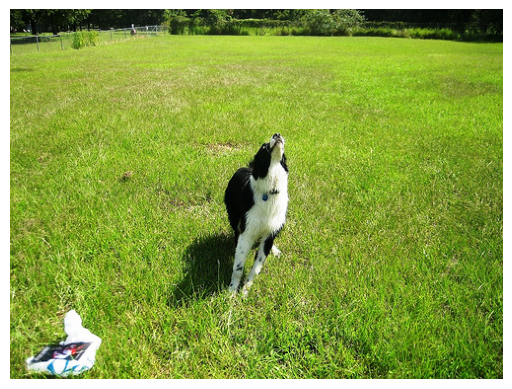

Cosine similarity between the input image and the test image embedding: 0.718 
['A black and white dog looking up .', 'A black and white dog stares up into the sky on a sunny day .', 'A dog in a grassy field , looking up .', 'A dog looking up in a grassy field .', 'The black and white dog is running on the grass .']


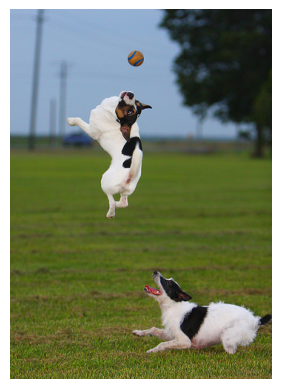

Cosine similarity between the input image and the test image embedding: 0.710 
['One dog leaps to catch a softball while another looks on .', 'The two dogs , one of which is leaping in the air , are chasing a ball outdoors .', 'two dogs jump for a ball on a green field .', 'Two dogs play catch with a ball in a field .', 'Two small dogs pursuing a ball across a grassy field .']


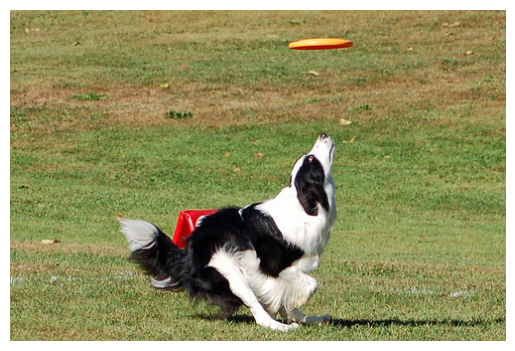

Cosine similarity between the input image and the test image embedding: 0.673 
['A black and white dog is going after an orange Frisbee .', 'A black and white dog leaps to catch an orange Frisbee .', 'A black and white dog prepares to catch a Frisbee .', 'a dog about to jump to catch a Frisbee', 'dog jumping for Frisbee']


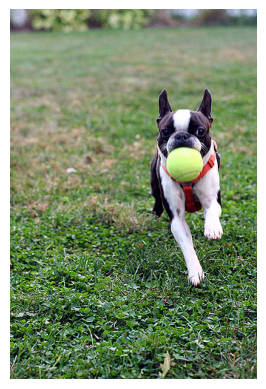

Cosine similarity between the input image and the test image embedding: 0.628 
['A dog is running with a yellow tennis ball and wearing a red harness .', 'a small black and white dog running through the grass with a tennis ball in his mouth', 'Small black and white dog wearing a red harness is running around with a ball in its mouth .', 'Small dog with red harness fetching a ball .', 'The dog wearing the red collar is running across the grass with a ball in its mouth .']


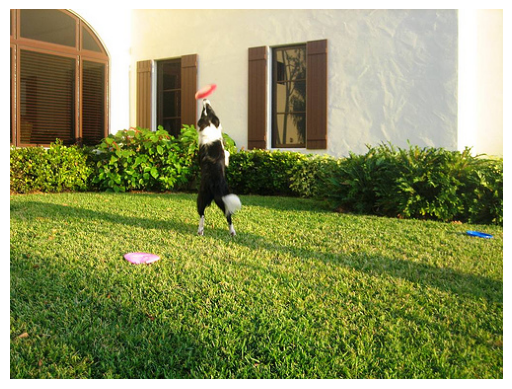

Cosine similarity between the input image and the test image embedding: 0.619 
['A black and white dog is catching a Frisbee in the yard .', 'A black and white dog is trying to catch a Frisbee in the air .', 'A dog jumps to catch a red Frisbee in the yard .', 'Dog is jumping up on a very green lawn to catch a Frisbee .', 'The black and white dog tries to catch a red Frisbee on green grass .']


In [111]:
k = 5
nn_idx, dist = find_nn(input_img_embedding, image_embeddings, k=k)

print(f"{k} nearest neighbours: {nn_idx}")

for idx, d in zip(nn_idx, dist):
  #item = test_dataset[idx]
  img = test_dataset.dataset[idx]['image']
  plt.imshow(img)
  plt.axis("off")
  plt.show()
  print(f"Cosine similarity between the input image and the test image embedding: {d:0.3f} ")
  print(test_dataset.raw_captions[idx])

## Displaying images based on the text input


In [112]:
#text_prompt = "a child looking at the sky"
text_prompt = "a man and a red car"

# Encode the text prompt and compute its embedding
# See how the text is tokenized inside the CLIPDataset class
tokenized_prompt= tokenizer(text_prompt, add_special_tokens=True, padding='max_length', truncation=True, max_length=Config.max_tokens)
tokenized_prompt = {key: tokenized_prompt[key] for key in tokenized_prompt}
print(tokenized_prompt)

input_txt_batch = txt_to_batch(tokenized_prompt, device)
print(input_txt_batch['input_ids'])
print(input_txt_batch['attention_mask'])

clip_model.eval()
text_prompt_embedding = clip_model.text_encoder(input_txt_batch['input_ids'], input_txt_batch['attention_mask'])
text_prompt_embedding = text_prompt_embedding.squeeze(0)   # Remove the batch dimension

print(f"Text embedding shape: {text_prompt_embedding.shape}")


{'input_ids': [101, 1037, 2158, 1998, 1037, 2417, 2482, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}
tensor([[ 101, 1037, 2158, 1998, 1037, 2417, 2482,  102,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0]],
       device='cuda:0')
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
       device='cuda:0')
Text embedding shape: torch.Size([256])


5 nearest neighbours: [701, 62, 369, 398, 190]


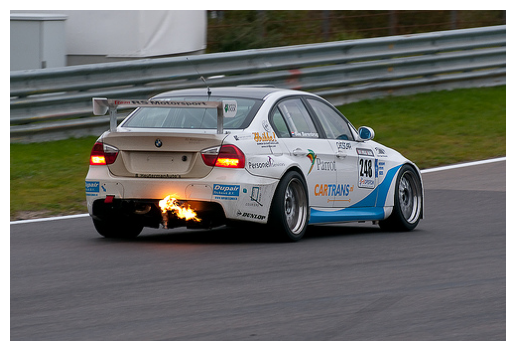

Cosine similarity between the input image and the test image embedding: 0.512 
['A race cars muffler catches on fire .', 'A race car sparks .', 'A sports car with flames coming out the exhaust .', 'The blue and white race car has flames coming out of its tail pipe .', 'The white racing car has fire bursting from its exhaust pipe .']


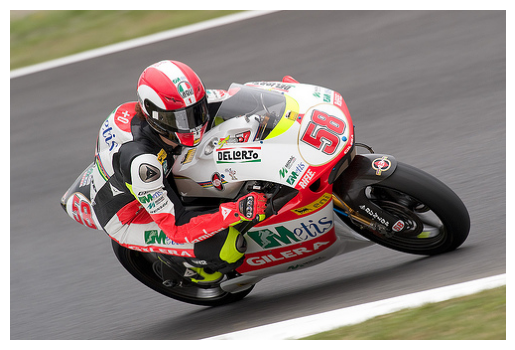

Cosine similarity between the input image and the test image embedding: 0.492 
['A man racing on a motorbike', 'A motorcycle rider drives fast around a curve on a track .', 'A person wearing a red and white uniform is racing a motorcycle with the number 58 on it .', 'A red and white motorcycle is being ridden around a bend on a racetrack .', 'Red and white motorbike number 58 races around the track .']


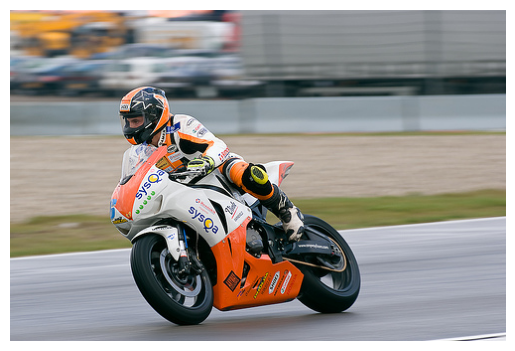

Cosine similarity between the input image and the test image embedding: 0.449 
['A man racing an orange motorcycle .', 'A man riding an orange and white motorcycle .', 'A motorcyclist races around a track .', 'An orange and white motorcycle is being ridden on a racetrack .', 'Someone is driving an orange motorbike along pavement .']


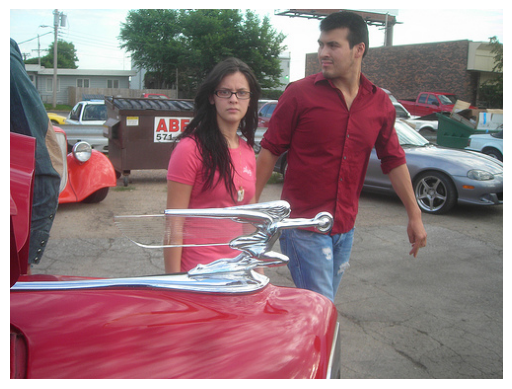

Cosine similarity between the input image and the test image embedding: 0.425 
['A couple in a parking lot .', 'A couple walks past a car in a parking lot .', 'A man and a woman are walking past a car with a fancy symbol on the front .', 'A man and a woman walk past a red car with a silver hood ornament', 'A man and woman walking next to a red car with an unusual hood ornament .']


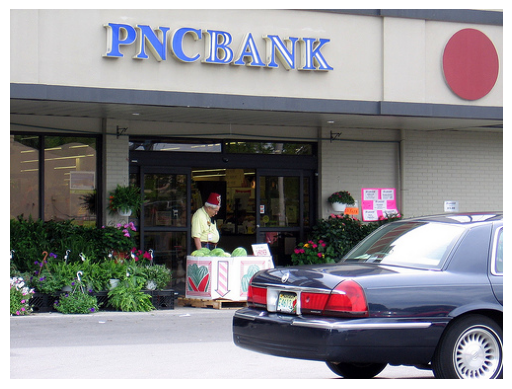

Cosine similarity between the input image and the test image embedding: 0.408 
['a man stands outside a bank selling watermelons .', 'A man with a red Shriner hat is looking at watermelons in front of a bank .', 'Dark colored Mercury car parked in front of PNC Bank .', 'The man is looking at watermelons for sale outside of a bank .', 'There is a man , wearing a funny hat , standing in front of a bank .']


In [113]:
nn_idx, dist = find_nn(text_prompt_embedding, image_embeddings, k=5)

print(f"{k} nearest neighbours: {nn_idx}")

for idx, d in zip(nn_idx, dist):
  #item = test_dataset[idx]
  img = test_dataset.dataset[idx]['image']
  plt.imshow(img)
  plt.axis("off")
  plt.show()
  print(f"Cosine similarity between the input image and the test image embedding: {d:0.3f} ")
  print(test_dataset.raw_captions[idx])